# FODO lattice

In [1]:
# few packages to import
import sympy as sy
import numpy as np
from ipywidgets import interactive
from sympy import init_session
init_session() 
la=np.linalg
%config IPCompleter.greedy=True
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # retina display

IPython console for SymPy 1.3 (Python 3.7.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.3/



## A simple FODO cell
In the following we will consider a FODO cell of length $L_{cell}$ in thin lens approximation, where 
1. the space of the focusing (F) and defocusing (D) quadrupoles is equal to $L_{cell}/2$ and
2. the focal length of the F and D quadrupoles equal in module, that is $f_D=-f_F$ with $f_F>0$.

For convenience we will start and end the FODO cell with half of an F quadrupole (i.e., with focal length $2\times f_F$).

In [2]:
L_cell=sy.Symbol('L_cell', positive=True, real=True);
f_F=sy.Symbol('f_F', positive=True, real=True);
f_D=sy.Symbol('f_D', positive=True, real=True);
f=sy.Symbol('f', positive=True, real=True);


QF_half=sy.Matrix([[1,0], [-1/(2*f),1]])
DRIFT=sy.Matrix([[1,L_cell/2], [0,1]])
QD=sy.Matrix([[1,0], [1/f,1]])

### The OTM in the x-plane

In [3]:
M_OTM=QF_half@DRIFT@QD@DRIFT@QF_half
M_OTM=sy.simplify(M_OTM)
M_OTM

⎡            2                2         ⎤
⎢      L_cell           L_cell          ⎥
⎢    - ─────── + 1      ─────── + L_cell⎥
⎢           2             4⋅f           ⎥
⎢        8⋅f                            ⎥
⎢                                       ⎥
⎢                                2      ⎥
⎢L_cell⋅(L_cell - 4⋅f)     L_cell       ⎥
⎢─────────────────────   - ─────── + 1  ⎥
⎢            3                  2       ⎥
⎣        16⋅f                8⋅f        ⎦

Now we need to study the eigenvalues and eigenvectors of the OTM.

In [4]:
eigenVectors=M_OTM.eigenvects()
eigenVectors=sy.simplify(eigenVectors)
eigenVectors

⎡⎛                                                                  ⎡⎡        
⎢⎜                                                                  ⎢⎢        
⎢⎜                                                                  ⎢⎢        
⎢⎜                                                                  ⎢⎢        
⎢⎜           ______________   ______________           2      2     ⎢⎢────────
⎢⎜  L_cell⋅╲╱ L_cell - 4⋅f ⋅╲╱ L_cell + 4⋅f    - L_cell  + 8⋅f      ⎢⎢        
⎢⎜- ──────────────────────────────────────── + ────────────────, 1, ⎢⎢  L_cell
⎢⎜                       2                              2           ⎢⎢- ──────
⎢⎜                    8⋅f                            8⋅f            ⎢⎢       2
⎢⎜                                                                  ⎢⎢    8⋅f 
⎢⎜                                                                  ⎢⎢        
⎣⎝                                                                  ⎣⎣        

                     ⎛      2         ⎞            

### Lattice Stability
We remeber that, for 1-D stable lattice, the 2 eigenvalues are in the form $\lambda_{1,2}=e^{\pm i\mu}$, where $\mu$ is the lattice phase advance. The sum of the two eivenvalues, $\lambda_1$ and $\lambda_2$, is $2\cos(\mu)$, then we can impose that  $-2<\lambda_1+\lambda_2<2$ to get the stability condition in the x-plane.  Due to the symmetry the stability on the y-plane follows (the OTM of the $y$-plane is similar to the one of the $x$-plane, therefore they shares the same eigenvalues).

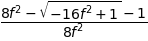

In [5]:
# First eigenvalue (in L_cell units)
sy.simplify(eigenVectors[0][0].subs(L_cell,1))

# Second eigenvalue (in L_cell units)
sy.simplify(eigenVectors[0][0].subs(L_cell,1))

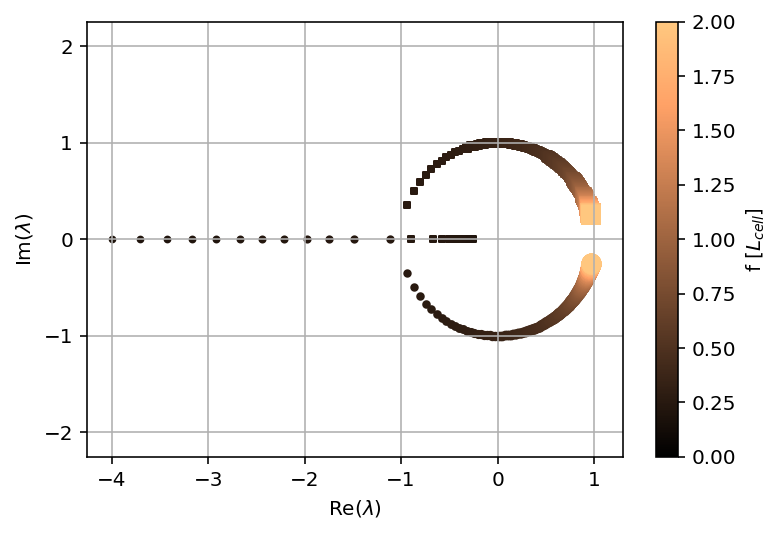

In [6]:
import cmath
def eig1(myf):
    return (8*myf**2-cmath.sqrt(-16*myf**2+1)-1)/(8*myf**2)

def eig2(myf):
    return (8*myf**2+cmath.sqrt(-16*myf**2+1)-1)/(8*myf**2)

colormap1 = plt.cm.copper
colormap2 = plt.cm.copper

normalize = matplotlib.colors.Normalize(vmin=0, vmax=2)
#plt.scatter(x, y, c=z, s=5, cmap=colormap, norm=normalize, marker='*')
for myf in np.linspace(0.2,2,400):
    aux=eig1(myf)
    plt.scatter([np.real(aux)],[np.imag(aux)],s=[myf*40],c=[myf],cmap=colormap1, norm=normalize )
    aux=eig2(myf)
    plt.scatter([np.real(aux)],[np.imag(aux)],s=[myf*40],c=[myf],cmap=colormap2,marker='s', norm=normalize)
plt.axis('equal')
plt.grid()
a=plt.colorbar()
a.set_label('f [$L_{cell}$]')
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)');
plt.savefig('/cas/images/eigenvaluesLocus.pdf')

In [7]:
aux=sy.solve([eigenVectors[0][0]+eigenVectors[1][0]<2,eigenVectors[0][0]+eigenVectors[1][0]>-2],f)
aux

The relation above states that if the quadrupoles are weak enough, $f>L_{cell}/4$, then the lattice is stable.

## Computing optics function

We will now compute the $\beta$-function at the center of the F and D quadrupoles. To do that we need to decompose the $M_{OTM}$ in diagonal form that is
\begin{equation}
M_{OTM}=P D P^{-1}
\end{equation}

It is important to remeber that if $M_{OTM}$ can be put in diagonal form then, infinite $P$ matrixes exist. In our convention we will chose the $P$ such that
1. its determinant is $-i$,
2. $P_{11}=P_{12}$.

In [8]:
# P definition
P=sy.Matrix([[eigenVectors[1][2][0][0]*eigenVectors[0][2][0][0],eigenVectors[0][2][0][0]*eigenVectors[1][2][0][0]],[eigenVectors[1][2][0][1]*eigenVectors[0][2][0][0],eigenVectors[0][2][0][1]*eigenVectors[1][2][0][0]]])
P=sy.simplify(P)
P=sy.simplify(P*(1/(sy.sqrt((P.det()*sy.I)))))
P

⎡                                  √f                                         
⎢     ───────────────────────────────────────────────────────────            ─
⎢           _____________________________________                             
⎢          ╱                 -ⅈ                                               
⎢         ╱  ─────────────────────────────────── ⋅(-L_cell + 4⋅f)             
⎢        ╱                     _________________                              
⎢       ╱                     ╱       2       2                               
⎢     ╲╱     (L_cell - 4⋅f)⋅╲╱  L_cell  - 16⋅f                               ╲
⎢                                                                             
⎢                                 -1                                          
⎢─────────────────────────────────────────────────────────────────────  ──────
⎢           _____________________________________    _________________        
⎢          ╱                 -ⅈ                     

In [9]:
# P inverse definition
Pinv=sy.simplify(P.inv())
Pinv

⎡           _____________________________________                             
⎢          ╱                 -ⅈ                                               
⎢         ╱  ─────────────────────────────────── ⋅(-L_cell + 4⋅f)             
⎢        ╱                     _________________                              
⎢       ╱                     ╱       2       2                               
⎢     ╲╱     (L_cell - 4⋅f)⋅╲╱  L_cell  - 16⋅f                                
⎢     ───────────────────────────────────────────────────────────       -√f⋅  
⎢                                 2⋅√f                                        
⎢                                                                             
⎢                                                                           ╲╱
⎢                                                                             
⎢                                  ⅈ                                          
⎢───────────────────────────────────────────────────

In [10]:
# D definition
D=sy.Matrix([[eigenVectors[1][0],0],[0,eigenVectors[0][0]]])
D=sy.simplify(D)
D

⎡                      _________________                                      
⎢        2            ╱       2       2       2                               
⎢- L_cell  + L_cell⋅╲╱  L_cell  - 16⋅f   + 8⋅f                                
⎢──────────────────────────────────────────────                        0      
⎢                        2                                                    
⎢                     8⋅f                                                     
⎢                                                                             
⎢                                                                      _______
⎢                                                        2            ╱       
⎢                                                - L_cell  - L_cell⋅╲╱  L_cell
⎢                      0                         ─────────────────────────────
⎢                                                                        2    
⎣                                                   

As sanity check we verify the diagonal form

In [11]:
display(sy.simplify(M_OTM))
aux=sy.simplify(P*D*Pinv)
print('*******\nCheck\n*******')
display(aux)

⎡            2                2         ⎤
⎢      L_cell           L_cell          ⎥
⎢    - ─────── + 1      ─────── + L_cell⎥
⎢           2             4⋅f           ⎥
⎢        8⋅f                            ⎥
⎢                                       ⎥
⎢                                2      ⎥
⎢L_cell⋅(L_cell - 4⋅f)     L_cell       ⎥
⎢─────────────────────   - ─────── + 1  ⎥
⎢            3                  2       ⎥
⎣        16⋅f                8⋅f        ⎦

*******
Check
*******


⎡            2                2         ⎤
⎢      L_cell           L_cell          ⎥
⎢    - ─────── + 1      ─────── + L_cell⎥
⎢           2             4⋅f           ⎥
⎢        8⋅f                            ⎥
⎢                                       ⎥
⎢                                2      ⎥
⎢L_cell⋅(L_cell - 4⋅f)     L_cell       ⎥
⎢─────────────────────   - ─────── + 1  ⎥
⎢            3                  2       ⎥
⎣        16⋅f                8⋅f        ⎦

and the P determinant is $-i$

In [12]:
sy.simplify(P.det())

### The cell phase advance 

As already recalled
\begin{equation}
\lambda_1+\lambda_2=2 \cos(\mu),
\end{equation}
then we get

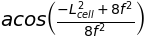

In [13]:
sy.acos((eigenVectors[0][0]+eigenVectors[1][0])/2)

that is 
\begin{equation}
\boxed{
\mu=\arccos \left(1-\frac{L_{cell}^2}{8 f^2}\right)
}
\end{equation}


and remembering that (https://www.wolframalpha.com/input/?i=sin(arccos(1-x)%2F2))
\begin{equation}
\sin\left(\frac{\arccos(1-x)}{2}\right)=\sqrt{\frac{x}{2}}
\end{equation}
we have

\begin{equation}
\boxed{
\sin\left(\frac{\mu}{2}\right)=\frac{L_{cell}}{4f}
}
\end{equation}

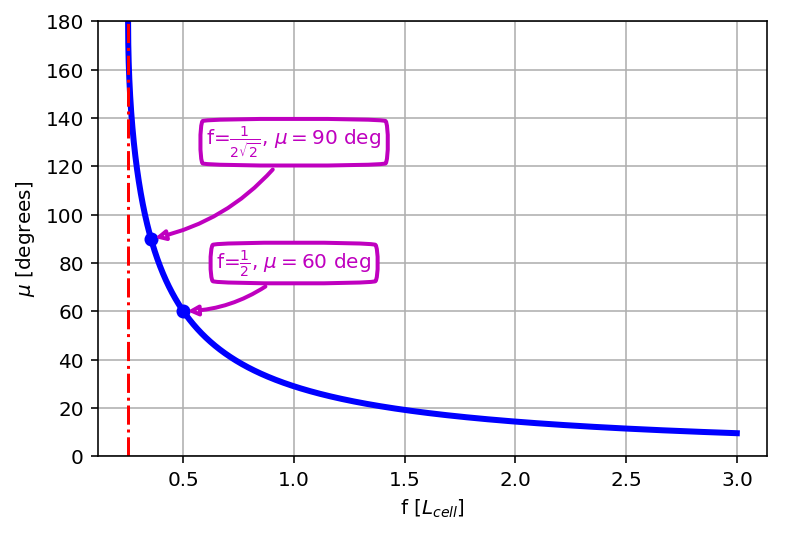

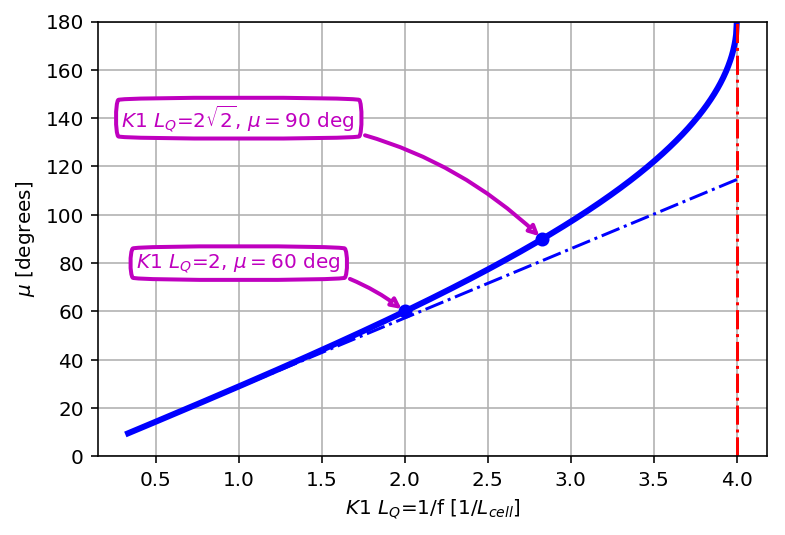

In [14]:
def mu_degrees(f):
    return np.arccos(1-1/8/f**2)/np.pi*180


myF=np.linspace(0.25, 3,10000)

def setArrowLabel(ax, label='myLabel',arrowPosition=(0,0),labelPosition=(0,0), myColor='k', arrowArc_rad=-0.2):
    return ax.annotate(label,
                  xy=arrowPosition, xycoords='data',
                  xytext=labelPosition, textcoords='data',
                  size=10, color=myColor,va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",color=myColor,lw=2),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad="+str(arrowArc_rad),
                                  fc="w", color=myColor,lw=2), 
                  )

plt.plot(myF,mu_degrees(myF),'b', lw=3)

plt.plot(.5,mu_degrees(.5),'ob')
plt.plot(.5/np.sqrt(2),mu_degrees(.5/np.sqrt(2)),'ob')

plt.plot([.25, .25],[0, 180],'-.r')
plt.ylim(0,180)
plt.xlabel('f [$L_{cell}$]')
plt.ylabel('$\mu$ [degrees]')
plt.grid()
setArrowLabel(plt.gca(), label='f=$\\frac{1}{2}$, $\mu=60$ deg ', labelPosition=(1, 80), arrowPosition=(0.5, 60), myColor='m',arrowArc_rad=-0.2)
setArrowLabel(plt.gca(), label='f=$\\frac{1}{2\sqrt{2}}$, $\mu=90$ deg ', labelPosition=(1, 130), arrowPosition=(.5/np.sqrt(2), 90), myColor='m',arrowArc_rad=-0.2)
plt.savefig('/cas/images/muOfFODO1.pdf')

plt.figure()

plt.plot(1/myF,mu_degrees(myF),'b',lw=3)
plt.plot(1/myF,mu_degrees(100)*100/myF,'-.b')
plt.plot([4, 4],[0, 180],'-.r')
plt.plot(1/.5,mu_degrees(.5),'ob')
plt.plot(1/(.5/np.sqrt(2)),mu_degrees(.5/np.sqrt(2)),'ob')

plt.xlabel('$K1\ L_Q$=1/f [$1/L_{cell}$]')
plt.ylabel('$\mu$ [degrees]')
plt.ylim(0,180)
setArrowLabel(plt.gca(), label='$K1\ L_Q$=2, $\mu=60$ deg ', labelPosition=(1, 80), arrowPosition=(1/0.5, 60), myColor='m',arrowArc_rad=-0.2)
setArrowLabel(plt.gca(), label='$K1\ L_Q$=$2\sqrt{2}$, $\mu=90$ deg ', labelPosition=(1, 140), arrowPosition=(1/(.5/np.sqrt(2)), 90), myColor='m',arrowArc_rad=-0.2)

plt.grid()
plt.savefig('/cas/images/muOfFODO2.pdf')


### Computing the $\beta$-function
Remebering that 
\begin{equation}
P=\left(
\begin{array}{cc}
\sqrt{\dfrac{\beta }{2}} &  \sqrt{\dfrac{\beta }{2}}\\[12pt]
\dfrac{-\alpha +i}{\sqrt{2\beta }} &   \dfrac{-\alpha -i}{\sqrt{2\beta}}\\
\end{array}
\right)
\end{equation}


the $\beta$-function at the start of the cell is $2\ P_{11}^2$, therefore

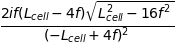

In [20]:
2*P[0]**2

The stability condition will ensure that the quantity above is positive. To simplify it we extract the abs.

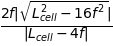

In [21]:
sy.functions.Abs(2*P[0]**2)

Therefore ($4 f> L$) we obtain that 
\begin{equation}
\beta_F=\frac{2f \sqrt{4f+L_{cell}} }{\sqrt{4f-L_{cell}}}
\end{equation}
and remembering that $\sin(\mu/2)=\frac{L_{cell}}{4f}$ we can write
\begin{equation}
\beta_F=2f \frac{ \sqrt{1+\sin(\mu/2)} }{\sqrt{1-\sin(\mu/2)}}=L_{cell} \frac{1}{2 \sin(\mu/2)} \frac{ \sqrt{1+\sin(\mu/2)} }{\sqrt{1-\sin(\mu/2)}}=\boxed{L_{cell} \frac{1+\sin(\mu/2)}{\sin(\mu)}}
\end{equation}

To get the $\beta_D$ it is enough to revaluate $2\ P_{11}^2$ after having replace $f$ with the $-f$. That is

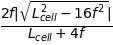

In [15]:
sy.functions.Abs(2*P[0].subs(f, -f)**2)

Therefore we obtain that 
\begin{equation}
\beta_D=2f \frac{ \sqrt{4f-L_{cell}} }{\sqrt{4f+L_{cell}}}
\end{equation}
and remembering that $\sin(\mu/2)=\frac{L_{cell}}{4f}$ we can write
\begin{equation}
\beta_D=2f \frac{ \sqrt{1-\sin(\mu/2)} }{\sqrt{1+\sin(\mu/2)}}=L_{cell} \frac{1}{2 \sin(\mu/2)} \frac{ \sqrt{1-\sin(\mu/2)} }{\sqrt{1+\sin(\mu/2)}}=\boxed{L_{cell} \frac{1-\sin(\mu/2)}{\sin(\mu)}}
\end{equation}

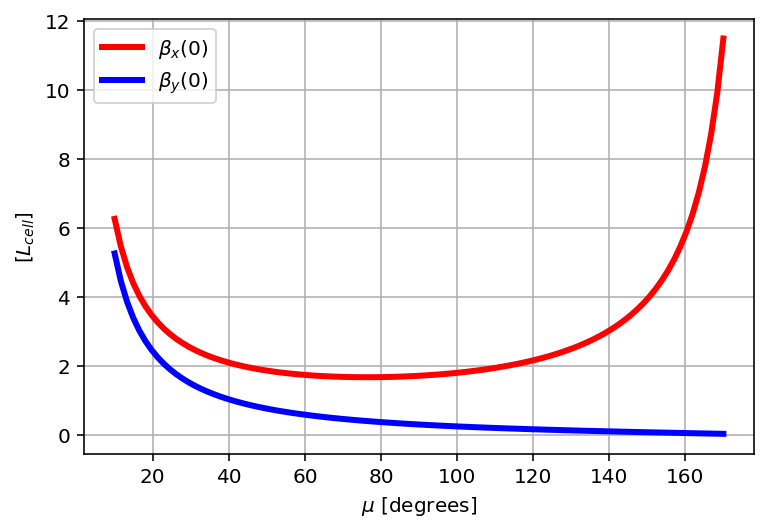

In [16]:
def betaF_L(mu_rad):
    return (1+np.sin(mu_rad/2))/np.sin(mu_rad)

def betaD_L(mu_rad):
    return (1-np.sin(mu_rad/2))/np.sin(mu_rad)

mu=np.linspace(10,170,100)
plt.plot(mu,betaF_L(mu/180*np.pi),'r', label='$\\beta_x(0)$', lw=3)
plt.plot(mu,betaD_L(mu/180*np.pi),'b', label='$\\beta_y(0)$', lw=3)
plt.grid()
plt.xlabel('$\mu$ [degrees]')
plt.ylabel('[$L_{cell}$]')
plt.legend(loc='best')
plt.savefig('/cas/images/betaOfFODO.pdf')


### Computing the $\alpha$-function
Remebering that 
\begin{equation}
P=\left(
\begin{array}{cc}
\sqrt{\dfrac{\beta }{2}} &  \sqrt{\dfrac{\beta }{2}}\\[12pt]
\dfrac{-\alpha +i}{\sqrt{2\beta }} &   \dfrac{-\alpha -i}{\sqrt{2\beta}}\\
\end{array}
\right)
\end{equation}


the $\alpha$-function at the start of the cell is $\boxed{- P_{11}(P_{21}+P_{22})}$, therefore

In [17]:
# at the center of the F quadrupole
P[0]*(P[2]+P[3])

In [18]:
# at the center of the D quadrupole
aux=P.subs(f, -f)
aux[0]*(aux[2]+aux[3])

We have then 
\begin{equation}
\alpha_F=\alpha_D=0
\end{equation}
that is in the quadrupoles we have local maxima or minima of the $\beta$-function.

### Chromaticity of a FODO
The definition of the linear chromaticity is 
\begin{equation}
\xi=\frac{\Delta Q}{\frac{\Delta p}{p_0}}
\end{equation}
and, for the single FODO cell,
\begin{equation}
\xi=\frac{1}{2 \pi}\frac{\Delta \mu}{\frac{\Delta p}{p_0}}
\end{equation}
From the definition of 
\begin{equation}
f\left(\frac{\Delta p}{p_0}\right)=f\times\left(1+\frac{\Delta p}{p_0}\right)
\end{equation}
and from
\begin{equation}
\sin\left(\frac{\mu}{2}\right)=\frac{L_{cell}}{4f}
\end{equation}
one can compute the FODO lattice chromaticity

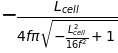

In [19]:
delta=sy.Symbol('delta', real=True);
pi=sy.Symbol('pi', real=True);
(sy.diff(1/pi*sy.asin(L_cell/(f*(1+delta))/4),delta)).subs(delta,0)

This means that
\begin{equation}
\xi=-\frac{1}{4\pi}\frac{L_{cell}}{f}\frac{1}{\cos(\mu/2)}=\boxed{-\frac{1}{\pi}\tan\left(\frac{\mu}{2}\right)}
\end{equation}


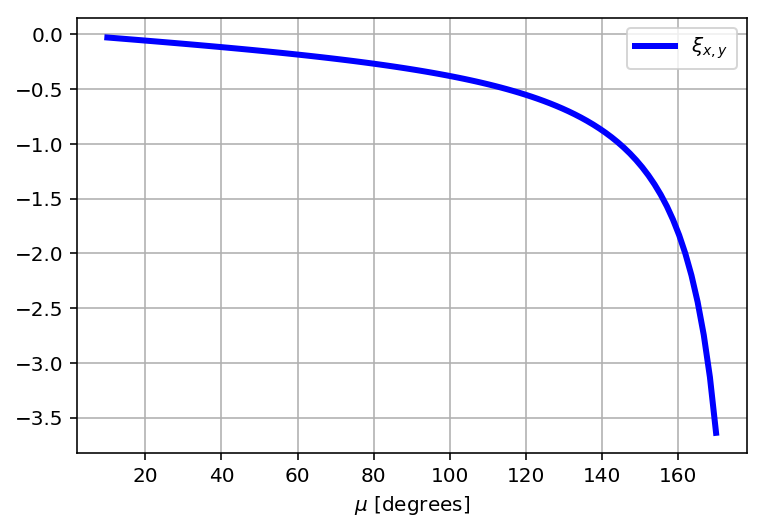

In [20]:
def chroma(mu_rad):
    return -1/np.pi*np.tan(mu_rad/2)



mu=np.linspace(10,170,100)
plt.plot(mu,chroma(mu/180*np.pi),'b', label='$\\xi_{x,y}$', lw=3)
plt.grid()
plt.xlabel('$\mu$ [degrees]')
#plt.ylabel('[$L_{cell}$]')
plt.legend(loc='best')
plt.savefig('/cas/images/chromaOfFODO.pdf')

# Other lattice topologies
We presented few results of on a simple FODO lattice
- stability,
- phase advance,
- $\beta$ and $\alpha$ function in the center of the quadrupoles,
- chromaticity.

A very similar approach can be followed for other topologies. We present few examples.

### FODO with $f_F\ne f_D$

In [21]:
L_cell=sy.Symbol('L_cell', positive=True, real=True);
f_F=sy.Symbol('f_F', positive=True, real=True);
f_D=sy.Symbol('f_D', positive=True, real=True);


QF_half=sy.Matrix([[1,0], [-1/(2*f_F),1]])
DRIFT=sy.Matrix([[1,L_cell/2], [0,1]])
QD=sy.Matrix([[1,0], [1/f_D,1]])

# STEP 1: OTM matrix
M_OTM=QF_half@DRIFT@QD@DRIFT@QF_half
M_OTM=sy.simplify(M_OTM)
M_OTM

⎡  L_cell⋅f_F   L_cell⋅(L_cell + 4⋅f_D)                                       
⎢  ────────── - ─────────────────────── + f_D⋅f_F                  2          
⎢      2                   8                                 L_cell           
⎢  ──────────────────────────────────────────────            ─────── + L_cell 
⎢                     f_D⋅f_F                                 4⋅f_D           
⎢                                                                             
⎢      2                                                                      
⎢L_cell    L_cell⋅f_D   L_cell⋅f_F                2                           
⎢─────── + ────────── - ────────── - f_D⋅f_F + f_F            2               
⎢   16         4            2                           L_cell     L_cell   L_
⎢──────────────────────────────────────────────────  - ───────── - ────── + ──
⎢                            2                         8⋅f_D⋅f_F   2⋅f_F    2⋅
⎣                     f_D⋅f_F                       

In [22]:
# STEP 2: eigen-decomposition 
eigenVectors=M_OTM.eigenvects()
eigenVectors=sy.simplify(eigenVectors)
eigenVectors

⎡⎛                                                                            
⎢⎜                                                                            
⎢⎜                                                                            
⎢⎜                                                                            
⎢⎜    ________   ___________________________________________   _______________
⎢⎜  ╲╱ L_cell ⋅╲╱ (L_cell - 4⋅f_F)⋅(L_cell + 4⋅f_D - 4⋅f_F) ⋅╲╱ L_cell + 4⋅f_D
⎢⎜- ──────────────────────────────────────────────────────────────────────────
⎢⎜                                   8⋅f_D⋅f_F                                
⎢⎜                                                                            
⎢⎜                                                                            
⎢⎜                                                                            
⎣⎝                                                                            

                                                   

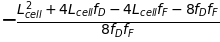

In [23]:
# Computation of cos(\mu)
(eigenVectors[0][0]+eigenVectors[1][0])/2

Now we want to find the domain in the $f_F$ and $f_D$ plane where -1<$\cos(\mu)$<1 for **BOTH** planes (it is important to note that there is an asymmetry between the planes for this configuration, $D(f_F, f_D)\ne D(-f_F,-f_D)$). 

In [24]:
# We express cos(\mu) assuming L_cell=1, that is we express f_F and f_D in units of L_cell.
def myFunc(f_F,f_D):
    if ((-(-8*f_D*f_F - 4*f_D + 4*f_F + 1)/(8*f_D*f_F))>=-1) and ((-(-8*f_D*f_F - 4*f_D + 4*f_F + 1)/(8*f_D*f_F))<=1):
        return 1
    else:
        return 0

vecFunc = np.vectorize(myFunc)

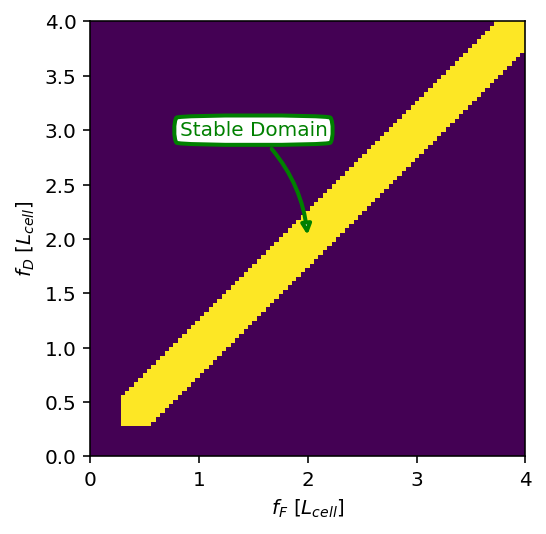

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
x,y = np.meshgrid(np.linspace(0.001,4,100),
                np.linspace(0.001,4,100))
z = vecFunc(x,y)*vecFunc(y,x)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]

plt.pcolor(x, y, z)
plt.xlabel('$f_F$ [$L_{cell}$]')
plt.ylabel('$f_D$ [$L_{cell}$]')
setArrowLabel(plt.gca(), label='Stable Domain', labelPosition=(1.5, 3), arrowPosition=(2,2), myColor='g',arrowArc_rad=-0.2)

plt.axis('square');
plt.savefig('/cas/images/stabilityFFFD_1.pdf')

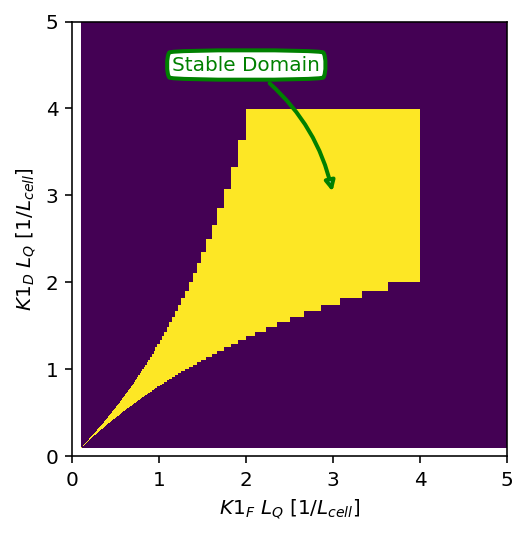

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

# generate 2 2d grids for the x & y bounds
x,y = np.meshgrid(np.linspace(0.00001,10,400),
                np.linspace(0.00001,10,400))
z = vecFunc(x,y)*vecFunc(y,x)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]


plt.pcolor(1/x, 1/y, z)
plt.axis('square')
plt.xlabel('$K1_F\ L_Q$ [$1/L_{cell}$]')
plt.ylabel('$K1_D\ L_Q$ [$1/L_{cell}$]')
setArrowLabel(plt.gca(), label='Stable Domain', labelPosition=(2, 4.5), arrowPosition=(3,3), myColor='g',arrowArc_rad=-0.2)

plt.xlim(0,5)
plt.ylim(0,5);
#plt.savefig('/cas/images/stabilityFFFD_2.pdf')

### Varying the quadrupole distance

In [28]:
L_cell=sy.Symbol('L_cell', positive=True, real=True);
f=sy.Symbol('f', positive=True, real=True);
r=sy.Symbol('r', positive=True, real=True);


QF=sy.Matrix([[1,0], [-1/(f),1]])
QF_half=sy.Matrix([[1,0], [-1/(2*f),1]])
# Please note that DRIFT1 length is not L_cell/2
DRIFT1=sy.Matrix([[1,r*L_cell], [0,1]])
QD=sy.Matrix([[1,0], [1/f,1]])
QD_half=sy.Matrix([[1,0], [1/(2*f),1]])
# Please note that DRIFT2 length is not L_cell/2
DRIFT2=sy.Matrix([[1,(1-r)*L_cell], [0,1]])


# STEP 1: OTM matrix in the x-plane, in the the other plane one has to change the sign of f
M_OTM=QF_half@DRIFT2@QD@DRIFT1@QF_half
M_OTM=sy.simplify(M_OTM)
M_OTM

⎡      2  2         2                                  2                   ⎛  
⎢L_cell ⋅r  - L_cell ⋅r - 2⋅L_cell⋅f⋅r + L_cell⋅f + 2⋅f             L_cell⋅⎝- 
⎢───────────────────────────────────────────────────────            ──────────
⎢                             2                                               
⎢                          2⋅f                                                
⎢                                                                             
⎢                  ⎛        2               ⎞                                 
⎢          -L_cell⋅⎝L_cell⋅r  - L_cell⋅r + f⎠             L_cell⋅f⋅(r - 1) + L
⎢          ───────────────────────────────────            ────────────────────
⎢                             3                                               
⎣                          4⋅f                                                

        2               ⎞          ⎤
L_cell⋅r  + L_cell⋅r + f⎠          ⎥
─────────────────────────          ⎥
       f           

In [29]:
M_OTM_Y=QD_half@DRIFT2@QF@DRIFT1@QD_half
M_OTM_Y=sy.simplify(M_OTM_Y)
M_OTM_Y

⎡      2  2         2                                  2                     ⎛
⎢L_cell ⋅r  - L_cell ⋅r + 2⋅L_cell⋅f⋅r - L_cell⋅f + 2⋅f               L_cell⋅⎝
⎢───────────────────────────────────────────────────────              ────────
⎢                             2                                               
⎢                          2⋅f                                                
⎢                                                                             
⎢                  ⎛        2               ⎞                                 
⎢           L_cell⋅⎝L_cell⋅r  - L_cell⋅r - f⎠             -L_cell⋅f⋅(r - 1) - 
⎢           ─────────────────────────────────             ────────────────────
⎢                             3                                               
⎣                          4⋅f                                                

        2               ⎞            ⎤
L_cell⋅r  - L_cell⋅r + f⎠            ⎥
─────────────────────────            ⎥
        f    

In [30]:
# STEP 2: eigen-decomposition 
eigenVectors=M_OTM.eigenvects()
eigenVectors=sy.simplify(eigenVectors)
eigenVectors

⎡⎛                                                                            
⎢⎜                                                                            
⎢⎜               _________________________________________                    
⎢⎜              ╱         ⎛      2  2         2        2⎞          2  2       
⎢⎜  L_cell⋅√r⋅╲╱  (r - 1)⋅⎝L_cell ⋅r  - L_cell ⋅r + 4⋅f ⎠    L_cell ⋅r  - L_ce
⎢⎜- ────────────────────────────────────────────────────── + ─────────────────
⎢⎜                              2                                            2
⎢⎜                           2⋅f                                          2⋅f 
⎢⎜                                                                            
⎢⎜                                                                            
⎣⎝                                                                            

                 ⎡⎡                                                           
                 ⎢⎢                                

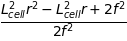

In [31]:
# Computation of cos(\mu)
((eigenVectors[0][0]+eigenVectors[1][0])/2)

We need to compare the previous expression with the one for r=0.5.
Therefore, for the stability condition, we can use the usual one by considering the equivalent $\tilde{L_{cell}}=L_{cell} 2\sqrt{r(r-1)}$.

### The triplet cell

Starting from the FODO we can consider other lattice cells. As an example, by putting back-to-back two OFOD's, we have a triplet cell (OFODDOFO).

In [32]:
L_cell=sy.Symbol('L_cell', positive=True, real=True);
f=sy.Symbol('f', positive=True, real=True);
r=sy.Symbol('r', positive=True, real=True);


QF=sy.Matrix([[1,0], [-1/(f),1]])
DRIFT=sy.Matrix([[1,L_cell/4], [0,1]])
QD=sy.Matrix([[1,0], [1/f,1]])


# STEP 1: OTM matrix in the x-plane, in the the other plane one has to change the sign of f
M_OTM=DRIFT@QF@DRIFT@QD@QD@DRIFT@QF@DRIFT
M_OTM=sy.simplify(M_OTM)
M_OTM

⎡      3         2                                               ⎤
⎢L_cell    L_cell ⋅f    3                                        ⎥
⎢─────── - ───────── + f         4           3         2         ⎥
⎢   32         4           L_cell    3⋅L_cell    L_cell          ⎥
⎢────────────────────────  ─────── - ───────── + ─────── + L_cell⎥
⎢            3                   3         2       8⋅f           ⎥
⎢           f               128⋅f      32⋅f                      ⎥
⎢                                                                ⎥
⎢                                       3         2              ⎥
⎢                                 L_cell    L_cell ⋅f    3       ⎥
⎢                                 ─────── - ───────── + f        ⎥
⎢ L_cell⋅(L_cell - 4⋅f)              32         4                ⎥
⎢ ─────────────────────           ────────────────────────       ⎥
⎢             3                               3                  ⎥
⎣          8⋅f                               f                

In [33]:
# STEP 2: eigen-decomposition 
eigenVectors=M_OTM.eigenvects()
eigenVectors=sy.simplify(eigenVectors)
eigenVectors

⎡⎛                                                                            
⎢⎜                                                                            
⎢⎜                                                                            
⎢⎜                                                                            
⎢⎜            ________________________________________________________________
⎢⎜           ╱                                  ⎛        2                    
⎢⎜  L_cell⋅╲╱  -(-L_cell + 4⋅f)⋅(-L_cell + 8⋅f)⋅⎝- L_cell  + 4⋅L_cell⋅f + 16⋅f
⎢⎜- ──────────────────────────────────────────────────────────────────────────
⎢⎜                                          3                                 
⎢⎜                                      32⋅f                                  
⎢⎜                                                                            
⎢⎜                                                                            
⎢⎜                                                  

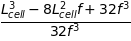

In [34]:
# Computation of cos(\mu)
((eigenVectors[0][0]+eigenVectors[1][0])/2)

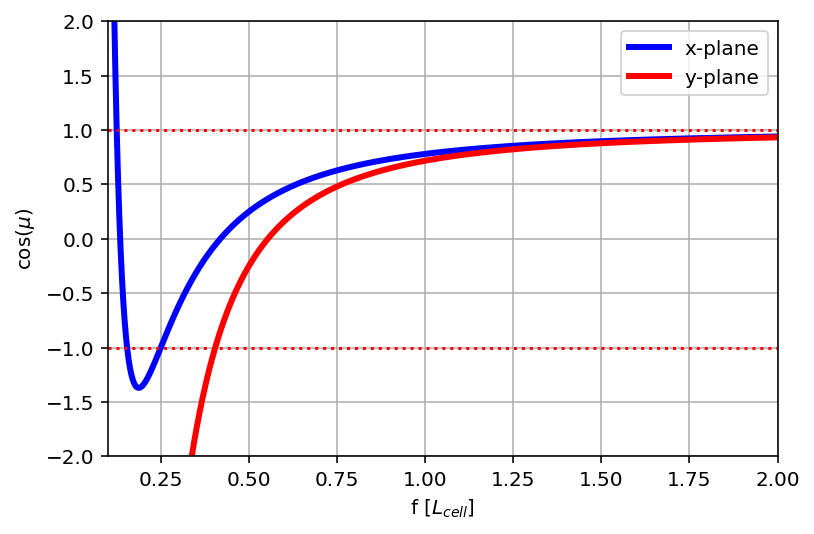

In [35]:
myF=np.linspace(0.1,2,1000)
plt.plot(myF, (1-8*myF+32*myF**3)/32/myF**3,'b',lw=3,label='x-plane')
plt.plot(myF, (1+8*myF+32*(-myF)**3)/32/(-myF)**3,'r',lw=3,label='y-plane')

plt.plot(myF, np.ones(np.shape(myF)),':r')
plt.plot(myF, -np.ones(np.shape(myF)),':r')
plt.ylim(-2,2)
plt.xlim(myF[0],myF[-1])
plt.grid()
plt.xlabel('f [$L_{cell}$]')
plt.ylabel('cos($\mu$)')
plt.legend(loc='best')

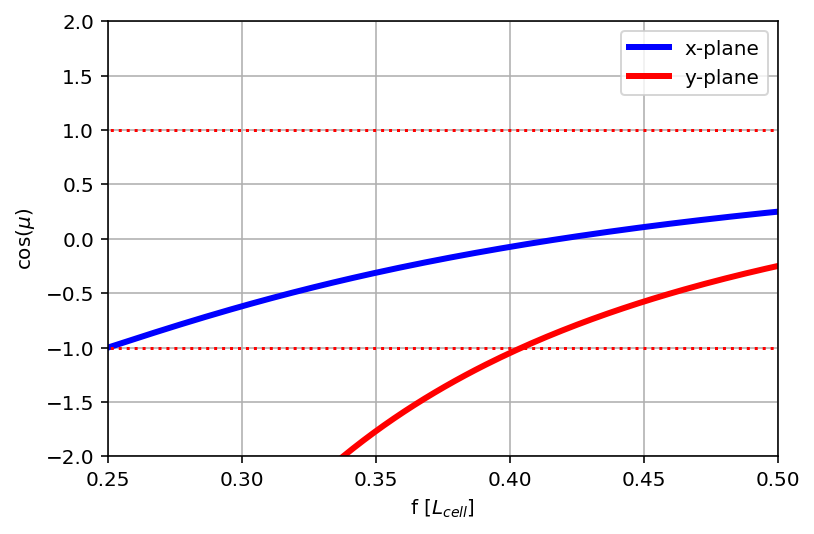

In [36]:
myF=np.linspace(0.1,2,1000)
plt.plot(myF, (1-8*myF+32*myF**3)/32/myF**3,'b',lw=3,label='x-plane')
plt.plot(myF, (1+8*myF+32*(-myF)**3)/32/(-myF)**3,'r',lw=3,label='y-plane')

plt.plot(myF, np.ones(np.shape(myF)),':r')
plt.plot(myF, -np.ones(np.shape(myF)),':r')
plt.ylim(-2,2)
plt.xlim(myF[0],myF[-1])
plt.grid()
plt.xlabel('f [$L_{cell}$]')
plt.ylabel('cos($\mu$)')
plt.legend(loc='best')
plt.ylim(-2,2)
plt.xlim(.25,.5);

Therefore in **this triplet topology** one has stability if 
\begin{equation}
\boxed{
f\gtrsim 0.40\ L_{cell}}
\end{equation}.

# MAD-X and FODO

In [37]:
from cpymad.madx import Madx
import matplotlib.patches as patches
from ipywidgets import interactive
def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha
    )
    )
    return;

## FODO with thick quadrupoles and dipoles

In [39]:
myMad = Madx(stdout=False)
f=50
l_quad=1
dipole_angle=0
def f(f, l_quad, dipole_angle):
    myString='''
    ! *********************************************************************
    ! Definition of parameters
    ! *********************************************************************
    option, rbarc=false;
    l_cell=100;
    quadrupoleLenght='''+format(l_quad) +''';
    f='''+format(f) +''';
    myAngle:='''+format(dipole_angle)+''';
    myK:=1/f/quadrupoleLenght;// m^-2
    
    ! *********************************************************************
    ! Definition of magnet
    ! ********************************************************************* 
    QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
    QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;
    SB: rbend, L=10, angle:=myAngle;
    SBhalf: rbend, L=5, angle:=myAngle;


    ! *********************************************************************
    ! Definition of sequence
    ! *********************************************************************
    myCell:sequence, refer=centre, L:=l_cell;
    SBhalf, at=2.5;
    sb1: SB, at =l_cell/8;
    quadrupole1: QF, at=l_cell/4;
    sb2: SB, at =3*l_cell/8;
    sb3: SB, at =4*l_cell/8;
    sb4: SB, at =5*l_cell/8;
    quadrupole2: QD, at=l_cell/4*3;
    sb5: SB, at =7*l_cell/8;
    SBhalf, at=97.5;
    endsequence;

    ! *********************************************************************
    ! Definition of beam
    ! *********************************************************************
    beam;

    ! *********************************************************************
    ! Use of the sequence
    ! *********************************************************************
    use, sequence=myCell;

    ! *********************************************************************
    ! TWISS
    ! *********************************************************************
    title, 'My first twiss';
    twiss;
    '''
    myMad.input(myString);

    myTwiss=myMad.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.04,.04)
    plt.title('First FODO, Q1='+format(myMad.table.summ.Q1[0],'2.3f')+', Q2='+ format(myMad.table.summ.Q2[0],'2.3f'))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')
    
    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='m')


    plt.ylim(-.11,.11)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b.-', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r.-', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.ylim(0,300)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$')
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    
    
interactive_plot = interactive(f, f=(30, 100, 1), l_quad=(0.1 ,10,.1),dipole_angle=(-0.1,0.1,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=65, description='f', min=30), FloatSlider(value=5.0, description='l_quad…

## Non linear off-momentum effect
In the following we will now consider the non-linear off momentum effects
- non-linear chromaticity
- non-linear dispersion
- off-momentum $\beta$-beating
in a simple FODO.

In [40]:
myMad = Madx(stdout=False)
f=30
l_quad=1
dipole_angle=0.005
myString='''
! *********************************************************************
! Definition of parameters
! *********************************************************************
option, rbarc=false;
l_cell=100;
quadrupoleLenght='''+format(l_quad) +''';
f='''+format(f) +''';
myAngle:='''+format(dipole_angle)+''';
myK:=1/f/quadrupoleLenght;// m^-2

! *********************************************************************
! Definition of magnet
! ********************************************************************* 
QF: quadrupole, L:=quadrupoleLenght, K1:=myK;
QD: quadrupole, L:=quadrupoleLenght, K1:=-myK;
SB: sbend, L=10, angle:=myAngle;
SBhalf: sbend, L=5, angle:=myAngle;


! *********************************************************************
! Definition of sequence
! *********************************************************************
myCell:sequence, refer=centre, L:=l_cell;
SBhalf, at=2.5;
sb1: SB, at =l_cell/8;
quadrupole1: QF, at=l_cell/4;
sb2: SB, at =3*l_cell/8;
sb3: SB, at =4*l_cell/8;
sb4: SB, at =5*l_cell/8;
quadrupole2: QD, at=l_cell/4*3;
sb5: SB, at =7*l_cell/8;
SBhalf, at=97.5;
endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************
beam;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

! *********************************************************************
! TWISS
! *********************************************************************
twiss,deltap=-0.1:0.1:0.005;
'''
myMad.input(myString);

myTwiss=myMad.table.twiss.dframe()

### Off-momentum tune shift

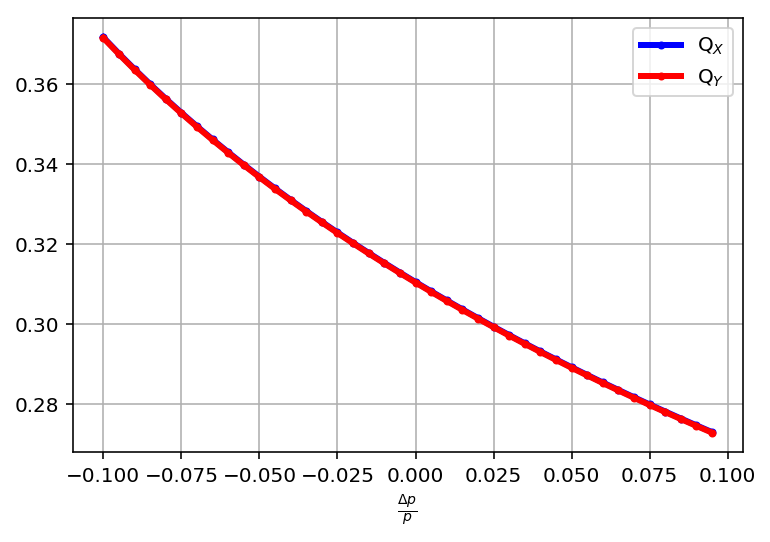

In [41]:
aux=myMad.table.summ.dframe()
plt.plot(aux['deltap'],aux['q1'],'.-b', lw=3, label='Q$_X$')
plt.plot(aux['deltap'],aux['q2'],'.-r', lw=3, label='Q$_Y$')

plt.grid()
plt.xlabel('$\\frac{\\Delta p}{p}$')
plt.legend(loc='best')

### Non-linear chromaticity

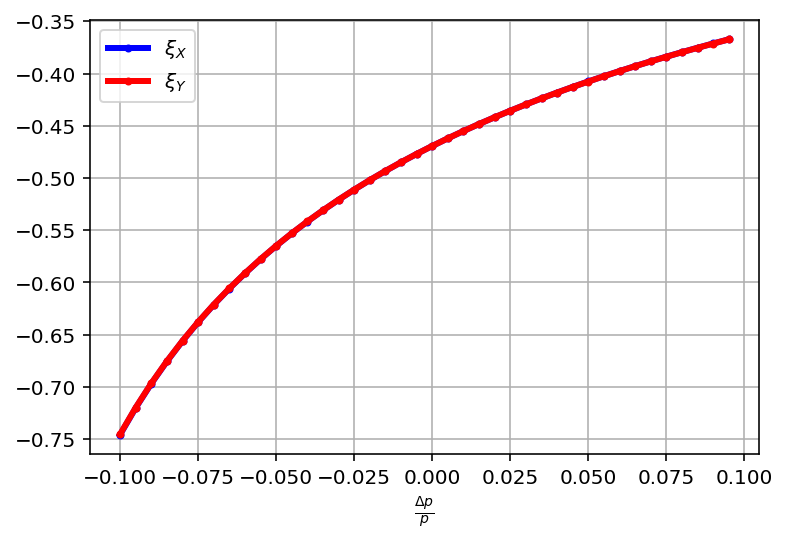

In [42]:
plt.plot(aux['deltap'],aux['dq1'],'.-b',lw=3, label='$\\xi_X$')
plt.plot(aux['deltap'],aux['dq2'],'.-r',lw=3, label='$\\xi_Y$')
plt.grid()
plt.xlabel('$\\frac{\\Delta p}{p}$')
plt.legend(loc='best')

### Off-momentum $\beta$-beating

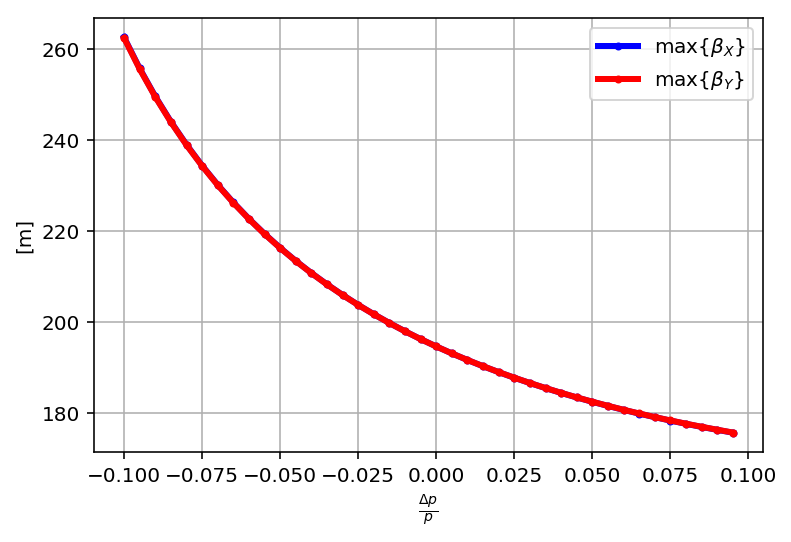

In [43]:
plt.plot(aux['deltap'],aux['betxmax'],'.-b',lw=3,label='max{$\\beta_X$}')
plt.plot(aux['deltap'],aux['betymax'],'.-r',lw=3,label='max{$\\beta_Y$}')

plt.grid()
plt.xlabel('$\\frac{\\Delta p}{p}$')
plt.ylabel('[m]')
plt.legend(loc='best')

### Non-linear dispersion

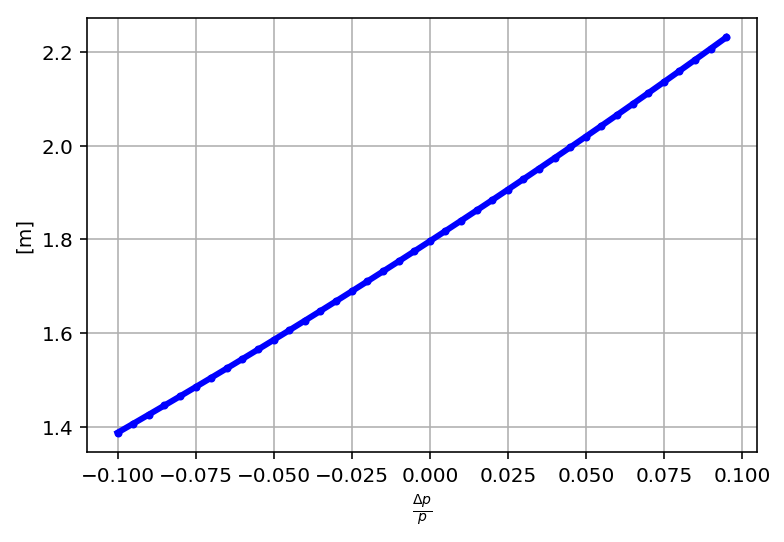

In [44]:
plt.plot(aux['deltap'],aux['dxmax'],'.-b', lw=3, label='max{$\\D_X$}')
plt.grid()
plt.xlabel('$\\frac{\\Delta p}{p}$')
plt.ylabel('[m]');